# Introduzione

Quanto segue è la realizzazione del progetto "House Prices Advanced Regression Techniques" prodotta da *Paolo Ciasco* & *Lorenzo Mancino*. Il work-flow deciso aprirà con un parte di feature engineering per poi testare vari modelli di apprendimento studiati all'interno del corso.
<!-- TBD -->



### Librerie Utilizzate

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # Display multipli in fase di output

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

from sklearn.feature_selection import SequentialFeatureSelector as SFS

### Dati a Disposizione

Essendo una competizione di Kaggle e non essendo il nostro scopo partecipare ad essa abbiamo dovuto sistemare i dati a disposizione affinché avessimo un dataset consistente e propedeutico al nostro scopo. I dati forniti da Kaggle, infatti, sono costruiti affinché tutte le persone possano concorrere su uno stesso testset con i target dello stesso inseriti in un ulteriore file .csv. Il nostro lavoro è stato di unire il train ed il testset (riportando i target nello stesso) per generare un unico dataset su cui ci concentreremo.

In [5]:
train_set = pd.read_csv("./train.csv") # Caricamento del trainset
test_set = pd.read_csv("./test.csv") # Caricamento del testset
target_set = pd.read_csv("./sample_submission.csv") # Caricamento del file ove sono presenti i target

SalePrice = target_set.SalePrice # Selezione della colonna dei target
#test_set = test_set.join(SalePrice) # Immissione della colonna dei target nel testset
#test_set.to_csv('test.csv', index=False) # Sovrascrittura del testset con quello sistemato

# Unione del testset sistemato con il trainset

data_support = pd.read_csv('test.csv')
frames = [train_set, data_support]
final = pd.concat(frames)
final.to_csv('dataset.csv', index=False) # Export del file

# Caricamento del dataset ottenuto

data = pd.read_csv('dataset.csv')

data = data.sample(frac = 1)


### Analisi Dei Dati

Viene effettuata ora un'analisi dei dati per vedere cosa abbiamo a disposizione per svolgere il task: fare regressione sul prezzo delle case.

Come prima cosa si mostra con quanti elementi stiamo lavorando ed il numero delle feature fornite.

In [ ]:
data.iloc[0:5, 0:5] # Porzione di dataframe

data.shape # Mostra le righe e le colonne del dataframe

data.iloc[1:3, 80:81] # Locazione del target

,Id,MSSubClass,MSZoning,LotFrontage,LotArea
2700,2701,60,RL,NaN,9019
2121,2122,50,RM,52.0,6240
2132,2133,30,RM,60.0,7200
1931,1932,60,RL,62.0,10429
827,828,20,RL,65.0,8529


(2919, 81)

,SalePrice
2121,162690.209132
2132,163474.633393


Il dataset fornito raccoglie $2919$ elementi e $81$ feature (includendo anche il target come 81esima feature). I dati forniti, inoltre, forniscono un utilissimo file .txt che descrive rapidamente le feature utilizzate.

Non essendo il dataset eccessivamente popolato, sebbene non verranno usate Neural Network, si decide di sfruttare la k-fold validation.
Essendo le feature un numero veramente elevato per una regressione del prezzo di una casa si decide di attuare la cosidetta Feature Engineering. 

### Feature Engineering

Come prima cosa si controlla l'eventuale assenza completa di dati in qualche colonna

In [ ]:
# Iterazione su tutte le colonne per controllare l'eventuale presenza di valori nulli su tutta l'intera colonna

for i in data.columns:
    if data[i].isnull().all():
        print(data[i])
    

Sfruttando la libreria *missingno* vogliamo mostrare una matrice di valori mancanti per trovare eventuali feature poco popolate su cui fare un'analisi ulteriore.

<AxesSubplot:>

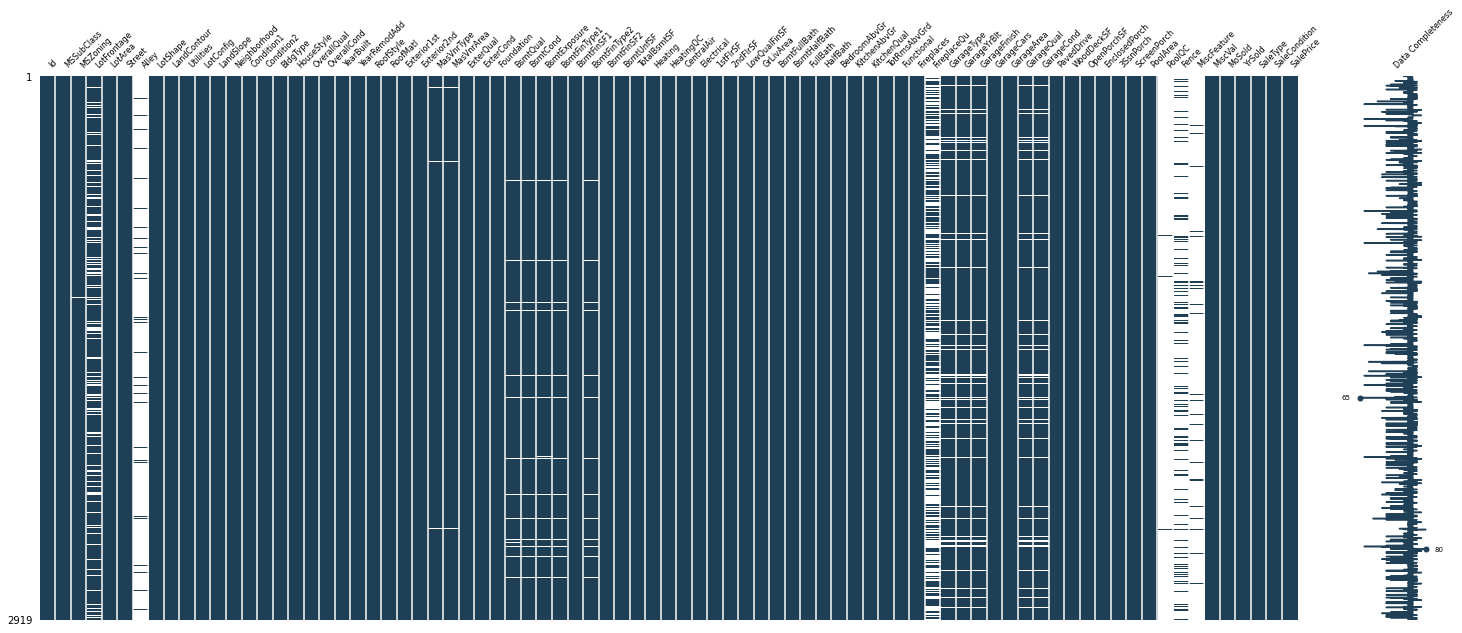

In [ ]:
msno.matrix(data, labels=True, fontsize=8, color = (0.12,0.25,0.34))


La prima feature che notiamo essere poco popolata è **Alley**, ovvero (seguendo le istruzioni fornite come specificato poco prima) la feature riguardante l'ingresso o meno da dei vicoli e, se presente, il materiale usato per lo stesso. In questo caso non è salutare eliminare direttamente la feature perché in realta i valori mancanti indicano il fatto che la casa non ha ingressi da vicoli che, in un ipotetico prezzo finale, è una caratteristica che è rilevante. Riguardo questo, utilizzeremo un metodo per "fillare" i valori nulli in modo tale che l'informazione venga preservata.

La seconda feature che coglie la nostra attenzione è **FireplaceQu**, ovvero la feature che esprime la qualità del camino se presente. Qui, a differenza di prima, ci annotiamo questa feature come potenzialmente "inutile" perchè è presente una ulteriore feature (**Fireplaces**) che descrive il numero di camini presenti nella casa. Sfrutteremo in seguito un'analisi di correlazione per confermare o meno questa ipotesi.

La terza feature che vediamo essere poco popolata è **PoolQC**, ovvero la feature che rappresenta la qualità della piscina se presente. Anche qui la feature viene memorizzata perché presente un'altra feature (**PoolArea**) che esprime i metri quadri della piscina. Ulteriori analisi e ragionamenti in seguito all'analisi di correlazione.

La quarta feature interessante è **Fence**, ovvero la feature che esprime la presenza o meno di una recizione e, se presente,la sua qualità. Come nel primo caso non possiamo ragionare su questa feature in quanto la presenza di una recizione è sicuramente un elemento a favore o meno di un prezzo.

L'ultima feature è **MiscFeature**, ovvero la feature che descrive elementi addizionali di una casa(ad es. Ascensore, Campo da Tennis, ...). Prendiamo nota di questa feature in quanto è presente una ulteriore feature (**MiscVal**) che esprime il valore totale di tutti gli elementi addizionali presenti. Anche qui verranno eseguite ulteriori analisi.


##### Data Processing

Cominciamo a lavorare sul dataset cominciando il preprocessing dei dati.
E' necessaria una piccola digressione su come possono essere presentate le feature. Si distinguono feature categoriche(ovvero che sono espresse tramite stringhe) da quelle numeriche ed a loro volta le stesse si dividono in categoriche nominali(non sensibili all'ordinamento) e categoriche ordinali. Il nostro obiettivo è quello di trasformare tutte le feature categoriche in numeriche affinché il modello abbia dati in ingresso omogenei e possiamo confrontare tutte le feature tra di loro per scovare eventuali correlazioni o altro.\
Viene presentato ora un esempio di feature **categorica nominale** che indica la classificazione dell'immobile in base alla zona dove risiede:

In [ ]:
data["MSZoning"]

2700    RL
2121    RM
2132    RM
1931    RL
827     RL
        ..
2487    RL
1669    RL
49      RL
2675    RL
2496    RL
Name: MSZoning, Length: 2919, dtype: object

Viene ora presentato, invece, un esempio di feature **categoria ordinale** che indica la qualità dei materiali della casa da un minimo di 1 a un massimo di 10:

In [ ]:
data["OverallQual"]

0       7
1       6
2       7
3       7
4       8
       ..
2914    4
2915    4
2916    5
2917    5
2918    7
Name: OverallQual, Length: 2919, dtype: int64

Quanto segue è la trasformazione di tutte le feature del dataset in numeri e, contemporaneamente, gestione dei valori nulli(NaN) del dataset; sfrutteremo il **Label Encoder** andando a sovrascrivere la colonna della feature selezionata con il nuovo valore. Ovviamente per quanto riguarda le feature categoriche ordinali seguiamo un approccio che preservi l'ordine tramite dizionari con le scale definite da noi.\
Il Label Encoder fornisce una codifica univoca per ogni colonna di feature. \
L'idea è quella di quella di riempire tutti i valori nulli con una stringa speciale "0000" e di assegnargli valore 0 sia nelle categoriche ordinali che nominali. Per quanto riguarda le colonne che ospitavano degli interi faremo una sostituzione finale sostituendo la stringa "0000" in tutto il dataset con 0.\
In questo modo abbiamo gestito sia i valori nulli del dataset che le feature categoriche.

In [6]:
%%capture 

# Definizione delle feature categoriche nominali per richiamarle poi nel ciclo for

categorical_nominal_features = ["MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig",
                                "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle",
                                "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
                                "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical",
                                "Functional", "GarageType", "PavedDrive", "MiscFeature", "SaleType",
                                "SaleCondition"]

# Definizione delle feature categoriche ordinali per richiamarle poi nel ciclo for

categorical_ordinal_features = [
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual",
    "GarageCond", "PoolQC", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "GarageFinish", "Fence"
]

# Scrittura delle scale differenti presenti nel dataset(prese dalla descrizione dei dati)

quality_scale_dict = {"0000":0, "NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
BstmExposure_dict = {"0000":0, "NA": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}
BsmtFinType_dict = {"0000":0, "NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
GarageFinish_dict = {"0000":0, "NA": 0, "Unf": 1, "RFn": 2, "Fin": 3}
Fence_dict = {"0000":0, "NA": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}

# Assegnazione delle scale alle feature(secondo la descrizione dei dati)

feature_scale_dict = {
    "ExterQual": quality_scale_dict,
    "ExterCond": quality_scale_dict,
    "BsmtQual": quality_scale_dict,
    "BsmtCond": quality_scale_dict,
    "HeatingQC": quality_scale_dict,
    "KitchenQual": quality_scale_dict,
    "FireplaceQu": quality_scale_dict,
    "GarageQual": quality_scale_dict,
    "GarageCond": quality_scale_dict,
    "PoolQC": quality_scale_dict,
    "BsmtExposure": BstmExposure_dict,
    "BsmtFinType1": BsmtFinType_dict,
    "BsmtFinType2": BsmtFinType_dict,
    "GarageFinish": GarageFinish_dict,
    "Fence": Fence_dict
}

data.fillna("0000", inplace=True) # Replace dei valori nulli con una stringa speciale che non è presente nel dataset

# Trasformazione tramite LabelEncoder delle feature categoriche nominali

le = LabelEncoder()

for feature in categorical_nominal_features:
    le.fit(data[feature])
    data[feature] = le.transform(data[feature])

# Trasformazione tramite apply rispetto il dizionario prima creato

for feature in categorical_ordinal_features:
    dict = feature_scale_dict[feature]
    data[feature] = data[feature].apply(lambda x: dict[x])


data.replace("0000", 0, inplace=True) # Replace finale per gestire colonne dove sono finite le stringhe speciali



### Modelli pre-feature engineering

In questa sezione verranno mostrati i risultati dei seguenti modelli(tramite 5-fold cross validation) sulle feature non ingegnerizzate:
- Linear Regression (baseline)
- Decision Tree
- Begging
- Gradient Boosting
- Random Forest
- KNN (non-parametric)

L'obiettivo sarà quello di confrontare l'evoluzione dei risultati post elaborazione delle feature. \
Il primo passo è quello di splittare il dataset in train e testset.


In [7]:
# Separazione del target dal dataset

X_data = data.drop(["SalePrice"], axis=1) #drop dalle colonne
Y_data = data["SalePrice"].values

#X_data, X_test, Y_data, Y_test = train_test_split(X_data, Y_data, test_size=0.20)



##### Linear Regression

Text(0.5, 0, 'Measured')

Text(0, 0.5, 'Predicted')

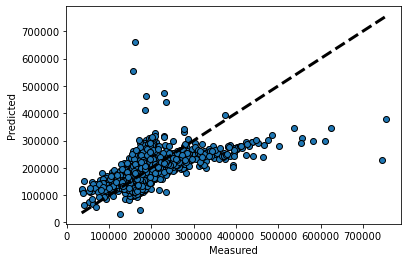

0.43900541160292317


In [ ]:
model1 = LinearRegression()
folds = KFold(n_splits = 5, shuffle = True, random_state = 98)
scores = cross_val_score(model1, X_data, Y_data, scoring='r2', cv=folds)
lin_predict = cross_val_predict(model1, X_data, Y_data, cv=5)

# Plot 

fig,  ax = plt.subplots()
ax.scatter(Y_data, lin_predict, edgecolors=(0,0,0))
ax.plot([Y_data.min(), Y_data.max()], [Y_data.min(), Y_data.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

#####
avg_score = np.mean(scores)
print(avg_score)


##### Decision Tree

Per quanto riguarda gli alberi di decisione decidiamo di usare le cross-fold validation per trovare l'iperparametro migliore per quanto riguarda la massima profondità degli stessi.

In [ ]:
params = {'max_depth': list(range(2,30))}
gscv = GridSearchCV(DecisionTreeRegressor(random_state = 42), params, verbose=1, cv = folds)

gscv.fit(X_data, Y_data)

gscv.best_estimator_


Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=98, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                       24, 25, 26, 27, 28, 29]},
             verbose=1)

DecisionTreeRegressor(max_depth=9, random_state=42)

In [ ]:
dt = DecisionTreeRegressor(random_state=42, max_depth=16, criterion='mse')

dt_scores = cross_val_score(dt, X_data, Y_data, cv=folds)
lin2_predict = cross_val_predict(dt, X_data, Y_data, cv=folds)

data["SalePrice"].values
lin2_predict

avg_score_dt = np.mean(dt_scores)
avg_score_dt

array([185199.37256814, 241000.        , 154849.04326898, ...,
       177500.        , 167411.02835165, 164700.        ])

array([187201.94208151, 189547.19987628, 158163.72092977, ...,
       175000.        , 166475.45758181, 171900.        ])

0.6790834666187447

##### Bagging

In [ ]:
params1 = {'n_estimators': list(range(2,15))}
gscv1 = GridSearchCV(BaggingRegressor(random_state = 42), params1, verbose=1, cv = folds)

gscv1.fit(X_data, Y_data)

gscv1.best_estimator_

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=98, shuffle=True),
             estimator=BaggingRegressor(random_state=42),
             param_grid={'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14]},
             verbose=1)

BaggingRegressor(n_estimators=14, random_state=42)

In [ ]:
bag_regr = BaggingRegressor(random_state=42, n_estimators=100)
bag_regr_scores = cross_val_score(bag_regr, X_data, Y_data, cv=folds)
bag_regr_val = cross_val_predict(bag_regr, X_data, Y_data, cv=folds)

avg_score_bag_regr = np.mean(bag_regr_scores)
avg_score_bag_regr

0.8584554378482144

##### Gradient Boosting

In [ ]:
params2 = {'n_estimators': list(range(2,100))}
gscv2 = GridSearchCV(GradientBoostingRegressor(random_state = 42), params2, verbose=1, cv = folds)

gscv2.fit(X_data, Y_data)

gscv2.best_estimator_

Fitting 5 folds for each of 98 candidates, totalling 490 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=98, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30,
                                          31, ...]},
             verbose=1)

GradientBoostingRegressor(n_estimators=99, random_state=42)

In [ ]:
grad_regr = GradientBoostingRegressor(random_state=42, n_estimators=100)
grad_regr_scores = cross_val_score(grad_regr, X_data, Y_data, cv=folds)
grad_regr_pred = cross_val_predict(grad_regr, X_data, Y_data, cv=folds)

avg_score_grad_regr = np.mean(grad_regr_scores)
avg_score_grad_regr

0.8323435000834405

##### Random Forest

In [ ]:
forest_regr = RandomForestRegressor(random_state=42, n_estimators=100)
forest_regr_scores = cross_val_score(forest_regr, X_data, Y_data, cv=folds)
forest_regr_pred = cross_val_predict(forest_regr, X_data, Y_data, cv=folds)

avg_score_forest_regr = np.mean(forest_regr_scores)
avg_score_forest_regr

0.8580695222412302

##### K Nearest Neighbors

In [ ]:
knn_regr = KNeighborsRegressor(n_neighbors=5)
knn_regr_scores = cross_val_score(knn_regr, X_data, Y_data, cv=folds)
knn_regr_pred = cross_val_predict(knn_regr, X_data, Y_data, cv=folds)

avg_score_knn_regr = np.mean(knn_regr_scores)
avg_score_knn_regr

0.5878948205087069

#### Correlazione tra feature

In questa parte faremo un'analisi rispetto alla correlazione tra feature per trovare eventuali feature collimabili.

L'idea è quella di creare una matrice di correlazione ed impostare una certa soglia affinché le feature sopra la stessa possano essere collimate secondo qualche logica.

In [ ]:

corr = data.corr(method="spearman") # Creazione della matrice di correlazione
corr.style.background_gradient(cmap='coolwarm').to_html('Correlation.html') # Export della matrice di correlazione


soglia0 = .60
soglia1 = .70
soglia2 = .80
soglia3 = .90
     
# Ricerca di valori maggiori di una certa soglia rispetto la matrice

#[f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(np.abs(corr.values) >= soglia0)) if i < j]
#[f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(np.abs(corr.values) >= soglia1)) if i < j]
[f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(np.abs(corr.values) >= soglia2)) if i < j]
#[f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(np.abs(corr.values) >= soglia3)) if i < j]


['YearBuilt and GarageYrBlt',
 'Exterior1st and Exterior2nd',
 'BsmtFinType1 and BsmtFinSF1',
 'BsmtFinType2 and BsmtFinSF2',
 'TotalBsmtSF and 1stFlrSF',
 'GrLivArea and TotRmsAbvGrd',
 'Fireplaces and FireplaceQu',
 'GarageCars and GarageArea',
 'PoolArea and PoolQC',
 'MiscFeature and MiscVal']

Le due feature **YearBuilt** e **GarageYrBlt** sono decisamente collimabili a favore della prima, nella maggior parte dei casi ci si aspetta che il garage sia stato costruito lo stesso anno della casa e comunque, anche se così non fosse, non è una situazione che fornisce peso importante al prezzo finale di vendita.

In [8]:

data.drop("GarageYrBlt", inplace=True, axis = 1)

Le due feature **Exterior1st** e **Exterior2nd** sono collimabili a favore della prima: è molto difficile che ci sia un secondo materiale specifico ricoprente la casa che rivesta una percentuale degna di nota ed in ogni caso esso non impatterebbe in modo rilevante sul prezzo finale di vendita.

In [9]:
data.drop("Exterior2nd", inplace=True, axis = 1)


Le due feature **GrLivArea** e **TotRmsAbvGrd** sono decisamente collimabili a favore della prima: non è tanto importante il numero di camere(seconda) quanto il quantitativo di metri quadri(dal livello 0 in su) quando stiamo parlando di prezzo.

In [10]:
data.drop("TotRmsAbvGrd", axis=1, inplace=True)

Le due feature **Fireplaces** e **FireplaceQu** sono collimabili a favore della seconda: se esiste un camino(o più) nella casa sarà espresso dalla seconda feature che contiene anche informazioni sulla qualità dello stesso e sulla presenza/assenza.

In [11]:
data.drop("Fireplaces", inplace=True, axis=1)

Le due feature **GarageArea** e **GarageCars** sono decisamente collimabili a favore della prima: è più rilevante di quanti metri quadri sia il posto auto interno alla casa che la capacità di macchine che può ospitare.

In [12]:
data.drop("GarageCars", inplace=True, axis=1)

Per le due feature **PoolArea** e **PoolQC** vale lo stesso discorso fatto per **Fireplaces**. Collimiamo a favore di **PoolQC**.

In [13]:
data.drop("PoolArea", inplace=True, axis=1)

Le due feature **MiscFeature** e **MiscVal** sono decisamente collimabili a favore della seconda in quanto rispecchia una summa di tutte le addizionalità presenti in una casa tramite il valore totale in dollari ed è quello che ci interessa a favore del prezzo finale.

In [14]:
data.drop("MiscFeature", inplace=True, axis=1)

Rispetto le feature rimanenti ci premiamo di esaminarle in ulteriori analisi a posteriori in quanto la decisione di come agire potrebbe essere deleteria rispetto alla predizione finale del prezzo di vendita.

Vengono ora mostrate le predizioni post cut delle feature indicate dei due modelli **Random Forest** e **Gradient Boosting**.

In [ ]:
X_data = data.drop(["SalePrice"], axis=1) # Ricaricare il trainset aggiornato


In [ ]:
forest_regr = RandomForestRegressor(random_state=42, n_estimators=100)
forest_regr_scores = cross_val_score(forest_regr, X_data, Y_data, cv=folds)
forest_regr_pred = cross_val_predict(forest_regr, X_data, Y_data, cv=folds)

avg_score_forest_regr = np.mean(forest_regr_scores)
avg_score_forest_regr

0.8561398041211138

In [ ]:
grad_regr = GradientBoostingRegressor(random_state=42, n_estimators=100)
grad_regr_scores = cross_val_score(grad_regr, X_data, Y_data, cv=folds)
grad_regr_pred = cross_val_predict(grad_regr, X_data, Y_data, cv=folds)

avg_score_grad_regr = np.mean(grad_regr_scores)
avg_score_grad_regr

0.835219535629871

# Features Selection: wrapper methods

In [32]:
def progress_bar(i, n, len, comment=''):
    s = "["

    n = max(1, n)
    i = max(0, i)
    i = min(i, n)

    q = i / n
    done = int(len * q)
    s += "=" * (done)

    if (done != len):
        s += ">"

    s += "-" * (len - done - 1)
    s += "] " + str(i) + "/" + str(n) + " " + comment

    return s


def print_deletable_line(s):
    print("\r" + s, end="")

def selection_analysis(model, X, y, direction='forward'):
    if direction not in ['forward', 'backward']:
        return False

    sfs = SFS(model, n_features_to_select=float(1), direction=direction, cv=None, scoring='r2', n_jobs=-1)

    n_features = len(X.columns)

    current_mask = np.zeros(shape=n_features, dtype=bool)

    feature_rank = []
    cv_scores = []

    for i in range(n_features):
        if direction == 'backward' and i == n_features-1:
            break

        print_deletable_line(progress_bar(i + 1, n_features, 20, direction + " selection."))

        new_feature_index = sfs._get_best_new_feature(model, X.values, y, current_mask)

        current_mask[new_feature_index] = True

        feature_rank.append(new_feature_index)

        if direction == 'forward':
            X_new = X.iloc[:, feature_rank]
        if direction == 'backward':
            X_new = X.drop(X_data.columns[feature_rank],axis=1)


        folds = KFold(n_splits=5, shuffle=True, random_state=98)
        cv_scores.append(cross_val_score(model, X_new, y, scoring='r2', cv=folds).mean())

    if direction == 'backward':
        i += 1
        print_deletable_line(progress_bar(i + 1, n_features, 20, direction + " selection."))
        feature_rank.append(np.where(current_mask == False)[0][0])
        feature_rank.reverse()

        cv_scores.reverse()
        folds = KFold(n_splits=5, shuffle=True, random_state=98)
        cv_scores.append(cross_val_score(model, X, y, scoring='r2', cv=folds).mean())

    print()
    return feature_rank, cv_scores

number_of_same_items = lambda x, y: sum([1 if a == b else 0 for a, b in zip(x, y)])

In [35]:
model = LinearRegression()
feature_rank_sfs, cv_scores_sfs = selection_analysis(model, X_data, Y_data, direction='forward')
feature_rank_sbs, cv_scores_sbs = selection_analysis(model, X_data, Y_data, direction='backward')

print("feature ranked in the same order: " + str(number_of_same_items(feature_rank_sfs, feature_rank_sbs)))
print("max score sfs: " + str(max(cv_scores_sfs)))
print("max score sbs: " + str(max(cv_scores_sbs)))


X_axis_data = range(1, len(X_data.columns)+1)

fig,  ax = plt.subplots()
ax.plot(X_axis_data, cv_scores_sfs, label='sfs')
ax.plot(X_axis_data, cv_scores_sbs, label='sbs')
ax.legend()
plt.show()

[==>-----------------] 11/80 forward selection.

KeyboardInterrupt: ignored